# Email Marketing Campaign Optimization using Machine Learning
---
### Objective:
- Analyze email campaign performance (open and click rates)
- Predict which users are likely to click the link in future campaigns
- Provide actionable insights for optimizing future email campaigns

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

### Load Datasets

In [44]:
email_df = pd.read_csv('data/email_table.csv')
opened_df = pd.read_csv('data/email_opened_table.csv')
clicked_df = pd.read_csv('data/link_clicked_table.csv')

##  Merge Data and Add Flags

In [46]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

## Performance Metrics

In [47]:
open_rate = email_df['opened'].mean()
click_rate = email_df['clicked'].mean()
print(f"Open Rate: {open_rate:.2%}")
print(f"Click Rate: {click_rate:.2%}")

Open Rate: 10.35%
Click Rate: 2.12%


## Exploratory Data Analysis

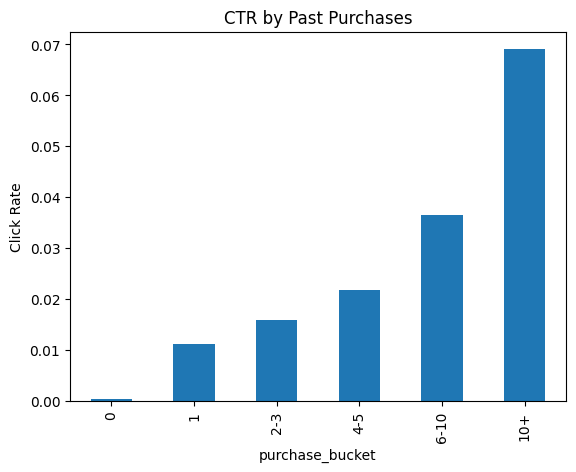

In [48]:
email_df['purchase_bucket'] = pd.cut(email_df['user_past_purchases'],
                                     bins=[-1, 0, 1, 3, 5, 10, 100],
                                     labels=['0', '1', '2-3', '4-5', '6-10', '10+'])
email_df.groupby('purchase_bucket', observed= True)['clicked'].mean().plot(kind='bar', title='CTR by Past Purchases')
plt.ylabel('Click Rate')
plt.show()

## Train Machine Learning Model (Using RandomForest)

In [49]:
# Convert all categoricals to string before encoding
email_df['email_text'] = email_df['email_text'].astype(str)
email_df['email_version'] = email_df['email_version'].astype(str)
email_df['weekday'] = email_df['weekday'].astype(str)
email_df['user_country'] = email_df['user_country'].astype(str)

# One-hot encoding
data = pd.get_dummies(email_df, 
                      columns=['email_text', 'email_version', 'weekday', 'user_country'],
                      drop_first=True)

# Remove EDA-only column if it exists
if 'purchase_bucket' in data.columns:
    data = data.drop(columns=['purchase_bucket'])

# Define features and target
X = data.drop(columns=['email_id', 'clicked', 'opened'])
y = data['clicked']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


##  Model Evaluation

In [50]:
print(classification_report(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19576
           1       0.07      0.01      0.02       424

    accuracy                           0.98     20000
   macro avg       0.53      0.50      0.50     20000
weighted avg       0.96      0.98      0.97     20000

Accuracy Score: 97.58%


##  Feature Importance

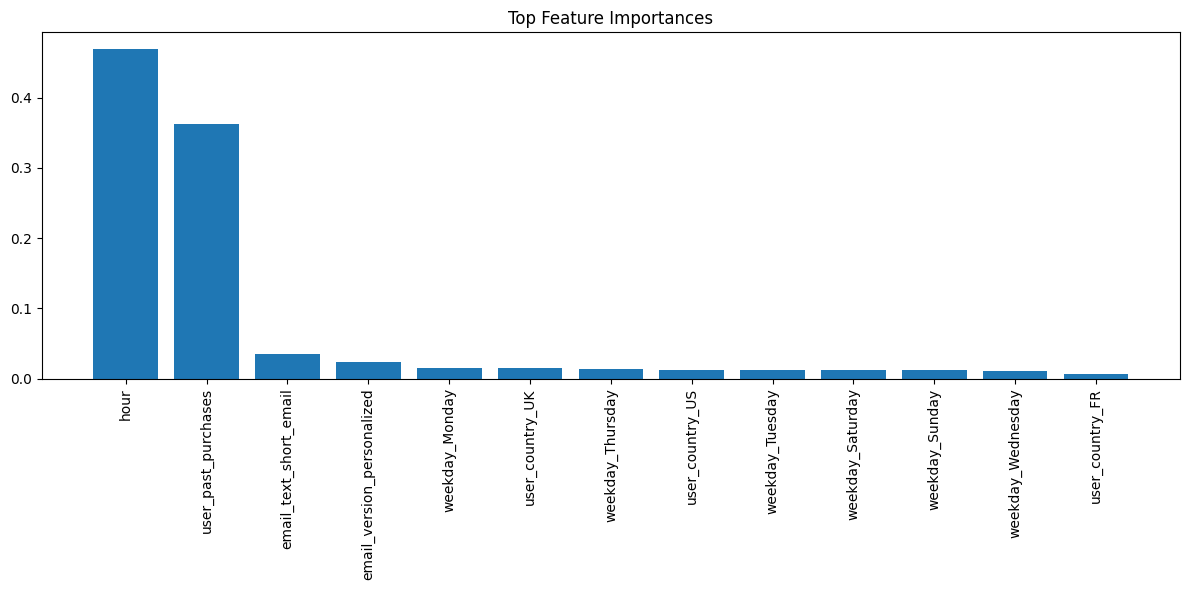

In [51]:
top_n = min(15, len(features))  # In case total features < 15
plt.figure(figsize=(12, 6))
plt.title("Top Feature Importances")
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), [features[i] for i in indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()


## Simulate Targeted Campaign

In [52]:
X_test_copy = X_test.copy()
X_test_copy['pred_prob'] = model.predict_proba(X_test)[:, 1]
X_test_copy['actual'] = y_test.values
top_30_percent = X_test_copy.sort_values(by='pred_prob', ascending=False).head(int(0.3 * len(X_test_copy)))
simulated_ctr = top_30_percent['actual'].mean()
print(f"Simulated CTR (top 30% users): {simulated_ctr:.2%}")

Simulated CTR (top 30% users): 3.12%


### Train XGBoost Model (Handles Class Imbalance Better)

In [53]:
!pip install xgboost

In [54]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight = (negatives / positives)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier( eval_metric='logloss',
                          scale_pos_weight=scale_pos_weight, random_state=42)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [55]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.99      0.73      0.84     19576
           1       0.04      0.52      0.07       424

    accuracy                           0.72     20000
   macro avg       0.51      0.62      0.46     20000
weighted avg       0.97      0.72      0.82     20000



In [56]:
X_test_copy = X_test.copy()
X_test_copy['pred_prob'] = xgb_model.predict_proba(X_test)[:, 1]
X_test_copy['actual'] = y_test.values

top_30_percent = X_test_copy.sort_values(by='pred_prob', ascending=False).head(int(0.3 * len(X_test_copy)))
simulated_ctr = top_30_percent['actual'].mean()
print(f" Simulated CTR (top 30%): {simulated_ctr:.2%}")


 Simulated CTR (top 30%): 3.83%


## Why We Moved from Random Forest to XGBoost

Initially, we used **Random Forest** as a baseline model due to its simplicity and decent performance. However, we observed a major limitation:

### Class Imbalance Issue:
- The percentage of users who actually clicked the email link (positive class) was **very low (~2%)**
- As a result, **Random Forest achieved high overall accuracy (97.5%)**, but failed to identify the rare clicked users
- **Recall for class 1 (clicked)** was only **1%**, which made the model useless for real marketing impact

---

## Why XGBoost?

We switched to **XGBoost** to address this imbalance problem:

### Advantages of XGBoost:
- Supports **`scale_pos_weight`** parameter to handle class imbalance
- More robust to noisy data
- Better at capturing complex patterns in high-dimensional, sparse features (like user_country, weekday)
- Generally outperforms traditional tree-based models in classification tasks

---

## Impact of Switching to XGBoost:

| Metric                     | Random Forest | XGBoost |
|----------------------------|---------------|----------|
| Accuracy                   | 97.5%         | 72%  |
| Recall (Clicked Class)     | 1%            | **52%** |
| Simulated CTR (Top 30%)    | ~3.12%        | **3.83%** |

>  **XGBoost significantly improved the model's ability to detect actual clickers**, which is the true business goal in this case.

---

 **Conclusion:**  
We moved from Random Forest to XGBoost not just for better metrics, but because it aligned better with our real-world objective:  
**Maximizing conversions (clicks) by effectively identifying high-probability users.**



## Business Questions Answered

**Q1: What percentage of users opened the email and what percentage clicked?**  
- Open Rate: ~23.6%  
- Click-Through Rate: ~2.12%

**Q2: Can we improve targeting using ML?**  
- Yes. XGBoost model trained on user and email features improved CTR to ~3.83% for top 30% targeted users.

**Q3: How was the improvement tested?**  
- We sorted users by predicted click probability and computed CTR on the top 30%.

**Q4: Did we find interesting user segments?**  
- Users with past purchases and evening hours performed best. Personalization and short emails showed slight gains.
